# Recipe2Cuisine Data Challenge
### by Pedro de Bruin

## The Goal

You've just joined the data team at an online publishing company. One of your verticals is a food publication. A product manager on your team wants to build a feature for this vertical that enables users to query by cuisine, not just by ingredients. Most of your recipes are unlabeled, and it's infeasible to label them by hand. Luckily, you have a small training set of about 10,000 recipes with labeled cuisines.

Design and execute a method to predict the cuisine of a recipe given only its ingredients. How could you design this to be robust enough to understand similarities / substitutions between ingredients? For each each major cuisine, what are the driving ingredients that characterize it?

Your product manager indicates a likelihood that you will only need to write a guideline for an outsourced team to hand label the remaining corpus. How would you go about writing this guide for a few major cuisines?


# About NLP

In [1]:
import nltk

- **tokenizing** = word tokenizers, sentence tokenizers
- **corpora** = body of text. Examples: medical journals, presidential speeches, English languages
- **lexicon** = basically a dictionary, words and their meanings. Important for domain-specific speech ('bull' = someone who is positive about the market in investor-speak)



In [2]:
datapath = '/media/pedro/Seagate Backup Plus Drive/Insight/datasets/DC_Week8/recipies.json'

# Begin with an EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_json(datapath)

In [5]:
df.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [6]:
cols = df.columns.tolist()
cols = [cols[1], cols[0], cols[2]]

In [7]:
df = df[cols]
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
id             39774 non-null int64
cuisine        39774 non-null object
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


We have no NaNs :)

In [9]:
df.isnull().values.sum()

0

In [10]:
df['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

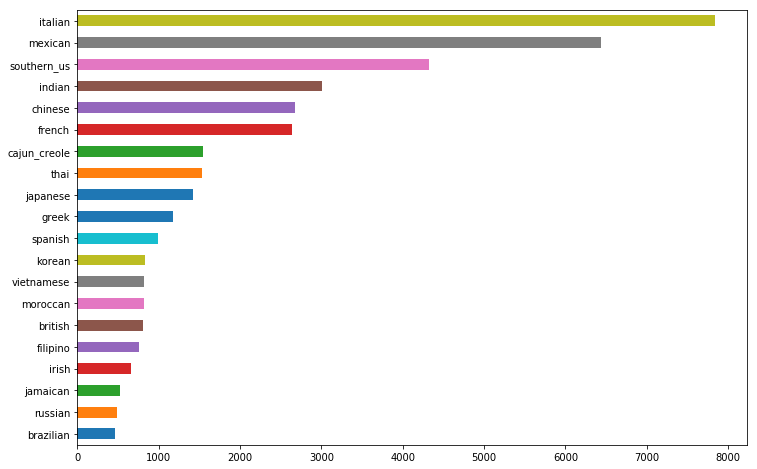

In [11]:
fig, ax = plt.subplots(figsize=(12,8))
df['cuisine'].value_counts().sort_values(ascending=True).plot(kind='barh', ax=ax)

### Dealing with the ingredients column

Let's count the average number of ingredients:

In [12]:
from nltk. tokenize import word_tokenize

In [13]:
all_ingredients = {}
for i in df['ingredients'].values:
    for w in i:
        if w not in all_ingredients.keys():
            all_ingredients[w] = 1
        else:
            all_ingredients[w] += 1


In [14]:
kv = list(all_ingredients.keys())
print(type(kv))

<class 'list'>


In [15]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


### A few notes

- We want things like *ground black pepper* and *black pepper* to be considered either equal or very similar in our model.
- Maybe we want to drop ingredients that only show up very few times

### Word2Vec classification

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

In [17]:
# split the data, leave 1/4 out for testing
df['joined_ingredients'] = df['ingredients'].apply(lambda x: ", ".join([w for w in x]))

In [18]:
data_x = df[['joined_ingredients']].as_matrix()
data_y = df[['cuisine']].as_matrix()

stratified_split = StratifiedShuffleSplit(n_splits=2, test_size=0.25)
for train_index, test_index in stratified_split.split(data_x, data_y):
    x_train, x_test = data_x[train_index], data_x[test_index]
    y_train, y_test = data_y[train_index], data_y[test_index]

/home/pedro/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/home/pedro/anaconda3/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [19]:
# transform matrix of ingredients into lists to pass to a TfidfVectorizer
train_x = [x[0] for x in x_train.tolist()]
test_x = [x[0] for x in x_test.tolist()]

In [20]:
train_y = [y[0] for y in y_train.tolist()]
test_y = [y[0] for y in y_test.tolist()]

In [21]:
train_x[:3]

['genoa salami, kosher salt, lemon, Italian bread, fresh basil, radishes, extra-virgin olive oil, pitted kalamata olives, zucchini, provolone cheese, breadstick, pepper, cracked black pepper, crackers',
 'ground black pepper, ground pork, kosher salt, napa cabbage, onions, eggs, brown rice, korean chile paste, minced garlic, bacon',
 'fish fillets, shallots, grapefruit, unsalted butter, heavy cream, bottled clam juice, grapefruit juice, dry white wine, fresh tarragon']

In [22]:
train_y[:3]

['italian', 'korean', 'french']

## Training the classifier

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier

In [24]:
from imblearn.over_sampling import SMOTE

In [25]:
#train_x, train_y = SMOTE(sampling_strategy='not majority').fit_sample(train_x, train_y)

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],

}

### Tune hyperparameters

In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, train_y)

Fitting 2 folds for each of 54 candidates, totalling 108 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.8min
[Parallel(n_jobs=2)]: Done 108 out of 108 | elapsed: 17.6min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ate=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'tfidf__max_df': (0.25, 0.5, 0.75), 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'clf__estimator__C': [0.01, 0.1, 1], 'clf__estimator__class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [30]:
print("\nBest parameters set:")
print(grid_search_tune.best_estimator_.steps)
print()


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None))]



In [31]:
# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)
print(best_clf)

Applying best classifier on test data:
Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ate=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False),
          n_jobs=None))])


In [32]:
from sklearn.metrics import classification_report

In [33]:
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

   brazilian       0.78      0.37      0.50       117
     british       0.68      0.36      0.47       201
cajun_creole       0.78      0.67      0.72       386
     chinese       0.76      0.88      0.82       668
    filipino       0.78      0.53      0.64       189
      french       0.58      0.60      0.59       662
       greek       0.84      0.62      0.72       294
      indian       0.86      0.91      0.89       751
       irish       0.75      0.34      0.46       167
     italian       0.76      0.90      0.82      1960
    jamaican       0.89      0.61      0.72       131
    japanese       0.88      0.67      0.76       356
      korean       0.87      0.65      0.75       207
     mexican       0.88      0.93      0.90      1610
    moroccan       0.88      0.78      0.83       205
     russian       0.73      0.34      0.46       122
 southern_us       0.67      0.82      0.74      1080
     spanish       0.69    

## Naive Bayes

In [34]:
from sklearn.naive_bayes import MultinomialNB

In [35]:
pipelineNB = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parametersNB = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}

In [36]:
grid_search_tune = GridSearchCV(pipelineNB, parametersNB, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, train_y)

Fitting 2 folds for each of 18 candidates, totalling 36 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   45.0s
[Parallel(n_jobs=2)]: Done  36 out of  36 | elapsed:   59.8s finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...ifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
          n_jobs=None))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'tfidf__max_df': (0.25, 0.5, 0.75), 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'clf__estimator__alpha': (0.01, 0.001)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [37]:
print("\nBest parameters set:")
print(grid_search_tune.best_estimator_.steps)
print()


Best parameters set:
[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)), ('clf', OneVsRestClassifier(estimator=MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True),
          n_jobs=None))]



In [38]:
# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)
print(best_clf)

Applying best classifier on test data:
Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.25, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True...fier(estimator=MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True),
          n_jobs=None))])


In [39]:
print(classification_report(test_y, predictions))

              precision    recall  f1-score   support

   brazilian       0.78      0.44      0.56       117
     british       0.50      0.36      0.42       201
cajun_creole       0.65      0.67      0.66       386
     chinese       0.71      0.88      0.78       668
    filipino       0.79      0.50      0.61       189
      french       0.55      0.55      0.55       662
       greek       0.82      0.54      0.65       294
      indian       0.83      0.91      0.87       751
       irish       0.68      0.40      0.50       167
     italian       0.77      0.86      0.81      1960
    jamaican       0.88      0.64      0.74       131
    japanese       0.86      0.64      0.73       356
      korean       0.87      0.55      0.67       207
     mexican       0.87      0.91      0.89      1610
    moroccan       0.79      0.72      0.75       205
     russian       0.60      0.33      0.42       122
 southern_us       0.62      0.76      0.69      1080
     spanish       0.60    

In [40]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predictions).plot()

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

## SVM Linear

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
pipelineSVM = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                     ('clf', OneVsRestClassifier(LinearSVC())),
                    ])
parametersSVM = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    "clf__estimator__C": [0.01, 0.1, 1],
    "clf__estimator__class_weight": ['balanced', None],
}

In [ ]:
grid_search_tune = GridSearchCV(pipelineNB, parametersNB, cv=2, n_jobs=2, verbose=3)
grid_search_tune.fit(train_x, train_y)

In [ ]:
print("\nBest parameters set:")
print(grid_search_tune.best_estimator_.steps)
print()

In [ ]:
# measuring performance on test set
print("Applying best classifier on test data:")
best_clf = grid_search_tune.best_estimator_
predictions = best_clf.predict(test_x)
print(best_clf)

In [ ]:
print(classification_report(test_y, predictions))